In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor

from econml.metalearners import TLearner
from econml.dml import DML

from econml.validate.drtester import DRtester

## Generate Data

Setting with 5 continuous covariates, 2 categorical treatments (and a control), and a continous outcome. Treatment assignment is based on the covariates and random noise. The outcome is based on covariates, treatment, and random noise. For the second treatment, the effect is conditional on the second covariate (X[:, 1]).

In [2]:
np.random.seed(123)

N = 20000  # number of units
K = 5  # number of covariates
num_treatments = 2 # number of treatments (excluding control)

# Generate random Xs
X_mu = np.zeros(5)  # Means of Xs
# Random covariance matrix of Xs
X_sig = np.diag(np.random.rand(5))
X = st.multivariate_normal(X_mu, X_sig).rvs(N)

# Effect of Xs on outcome
X_beta = np.random.uniform(0, 5, K)
# Effect of treatment on outcomes
D_beta = np.array([0, 1, 2])
# Effect of treatment on outcome conditional on X1
DX1_beta = np.array([0, 0, 3])

# Generate treatments based on X and random noise
beta_treat = np.random.uniform(-1, 1, (num_treatments + 1, K))
D1 = np.zeros((N, num_treatments + 1))
for k in range(num_treatments + 1):
    D1[:, k] = X @ beta_treat[k, :] + np.random.gumbel(0, 1, N)
D = np.array([np.where(D1[i, :] == np.max(D1[i, :]))[0][0] for i in range(N)])
D_dum = pd.get_dummies(D)

# Generate Y (based on X, D, and random noise)
Y_sig = 1  # Variance of random outcome noise
Y = X @ X_beta + (D_dum @ D_beta) + X[:, 1] * (D_dum @ DX1_beta) + np.random.normal(0, Y_sig, N)
Y = Y.to_numpy()

# Split into training/validation samples
train_prop = .5
train_N = np.ceil(train_prop * N)
ind = np.array(range(N))
train_ind = np.random.choice(N, int(train_N), replace=False)
val_ind = ind[~np.isin(ind, train_ind)]

Xtrain, Dtrain, Ytrain = X[train_ind], D[train_ind], Y[train_ind]
Xval, Dval, Yval = X[val_ind], D[val_ind], Y[val_ind]

## Validation
We use a simple (un-tuned) random forest classifier to predict treatment and an un-tuned gradient boosted regressor to predict outcomes. In the true data, there is heterogeneity by the second covariate (X[:, 1]) for the second treatment (D = 2) but not for the first (D = 1). Therefore, we should see a more significant blp_est, more significant qini coefficient, and higher calibration r-squared for the second treatment. We can also plot the calibration for each treatment. There should be a strong positive relationship for treatment 2 but a flat relationship for treatment 1.

We test two CATE models: a double machine learning (DML) estimator and a simple T-learner.

In [3]:
model_regression = GradientBoostingRegressor(random_state=0)
model_propensity = RandomForestClassifier(random_state=0)

In [4]:
est_t = TLearner(models=model_regression)
est_dm = DML(model_y=model_regression, model_t=model_propensity, model_final=model_regression, discrete_treatment=True)

est_t.fit(Ytrain, Dtrain, X=Xtrain)
est_dm.fit(Ytrain, Dtrain, X=Xtrain)

The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.


### DML

In [5]:
# Initialize DRtester and fit/predict nuisance models
dml_tester = DRtester(
    model_regression=model_regression, 
    model_propensity=model_propensity, 
    cate=est_dm
).fit_nuisance(Xval, Dval, Yval, Xtrain, Dtrain, Ytrain)

res_dml = dml_tester.evaluate_all(Xval, Xtrain)
res_dml.summary()

,treatment,blp_est,blp_se,blp_pval,qini_est,qini_se,qini_pval,autoc_est,autoc_se,autoc_pval,cal_r_squared
0,1,-0.137,0.142,0.335,-0.015,0.021,0.242,-0.032,0.063,0.306,-5.506
1,2,1.003,0.062,0.000,0.375,0.024,0.000,1.026,0.060,0.000,0.090


<Axes: title={'center': 'Treatment = 1, Calibration R^2 = -9.163'}, xlabel='Group Mean CATE', ylabel='GATE'>

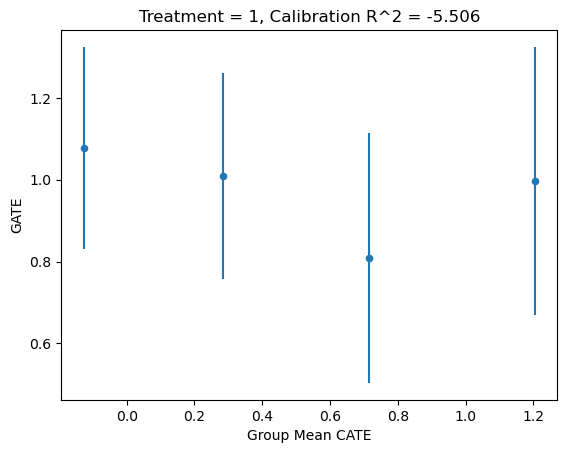

In [6]:
res_dml.plot_cal(1)

<Axes: title={'center': 'Treatment = 2, Calibration R^2 = -0.178'}, xlabel='Group Mean CATE', ylabel='GATE'>

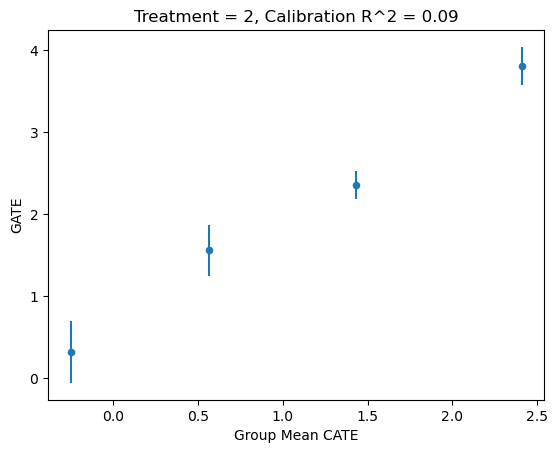

In [7]:
res_dml.plot_cal(2)

<Axes: title={'center': 'Treatment = 1, Integral = -0.015 +/- 0.021'}, xlabel='Percentage treated', ylabel='Gain over Random'>

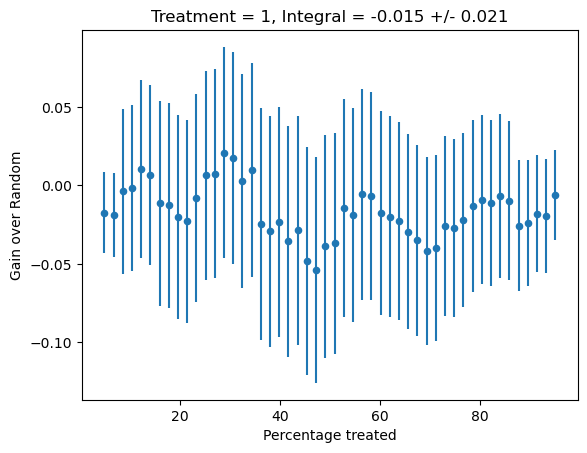

In [8]:
res_dml.plot_qini(1)

<Axes: title={'center': 'Treatment = 2, Integral = 0.373 +/- 0.024'}, xlabel='Percentage treated', ylabel='Gain over Random'>

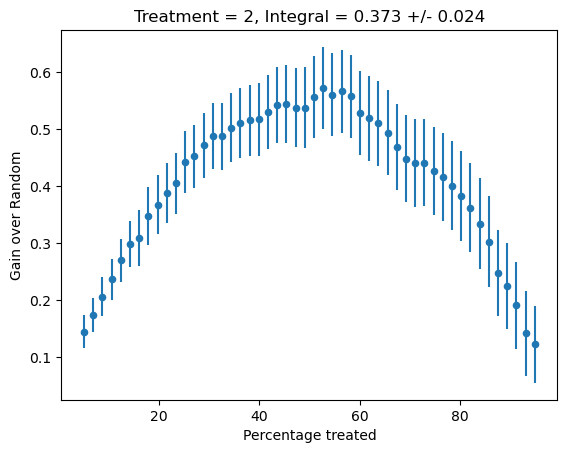

In [9]:
res_dml.plot_qini(2)

<Axes: title={'center': 'Treatment = 1, Integral = -0.032 +/- 0.063'}, xlabel='Percentage treated', ylabel='Gain over Random'>

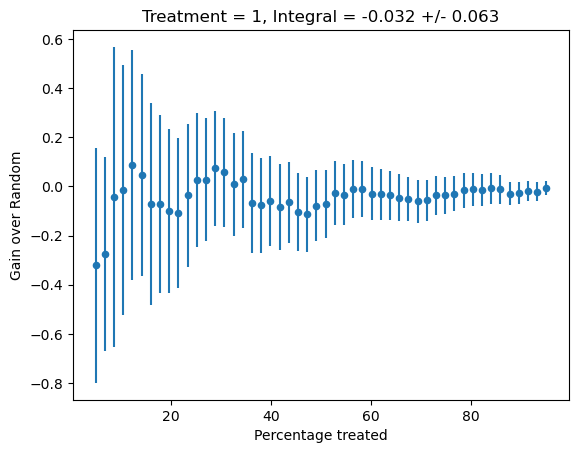

In [10]:
res_dml.plot_toc(1)

<Axes: title={'center': 'Treatment = 2, Integral = 1.026 +/- 0.06'}, xlabel='Percentage treated', ylabel='Gain over Random'>

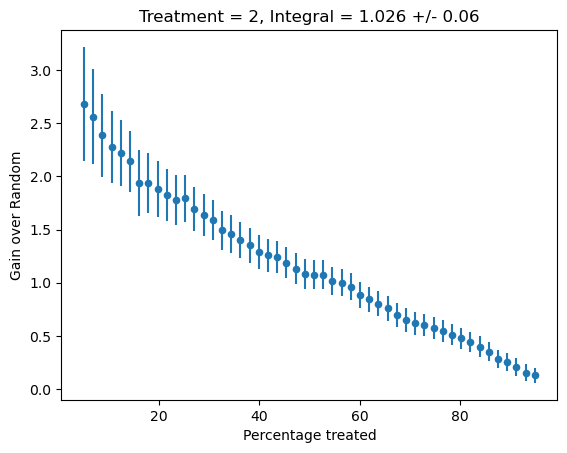

In [11]:
res_dml.plot_toc(2)

### T-Learner

In [12]:
# Initialize DRtester and fit/predict nuisance models
t_tester = DRtester(
    model_regression=model_regression, 
    model_propensity=model_propensity, 
    cate=est_t
).fit_nuisance(Xval, Dval, Yval, Xtrain, Dtrain, Ytrain)

res_t = t_tester.evaluate_all(Xval, Xtrain)
res_t.summary()

,treatment,blp_est,blp_se,blp_pval,qini_est,qini_se,qini_pval,autoc_est,autoc_se,autoc_pval,cal_r_squared
0,1,-0.184,0.111,0.098,-0.044,0.022,0.023,-0.083,0.057,0.071,-2.747
1,2,0.717,0.060,0.000,0.371,0.025,0.000,1.028,0.059,0.000,0.626


<Axes: title={'center': 'Treatment = 1, Calibration R^2 = -2.623'}, xlabel='Group Mean CATE', ylabel='GATE'>

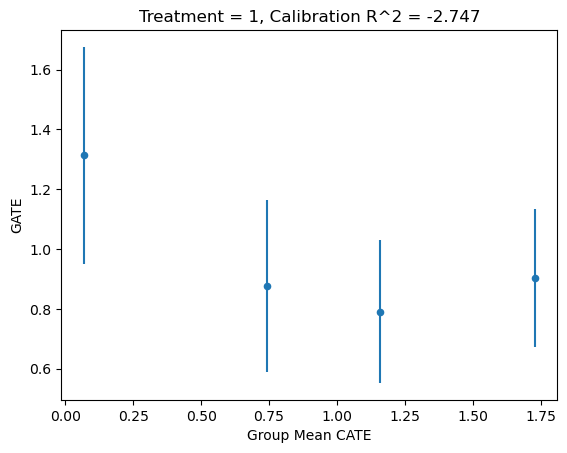

In [13]:
res_t.plot_cal(1)

<Axes: title={'center': 'Treatment = 2, Calibration R^2 = 0.627'}, xlabel='Group Mean CATE', ylabel='GATE'>

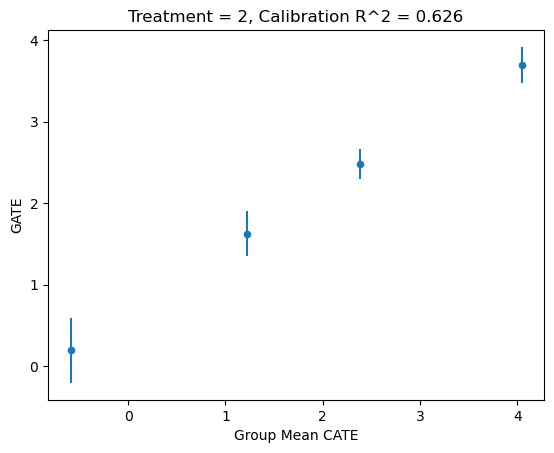

In [14]:
res_t.plot_cal(2)

<Axes: title={'center': 'Treatment = 1, Integral = -0.044 +/- 0.022'}, xlabel='Percentage treated', ylabel='Gain over Random'>

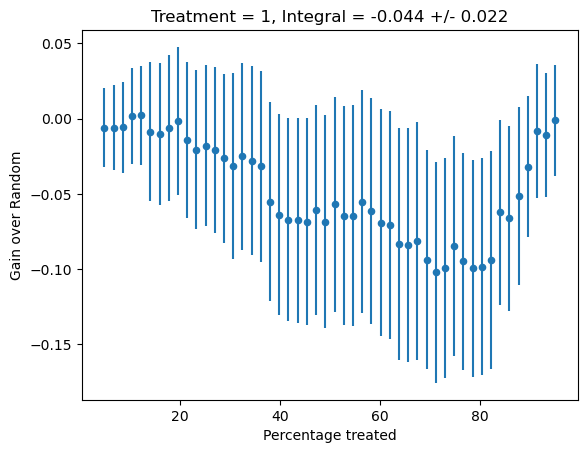

In [15]:
res_t.plot_qini(1)

<Axes: title={'center': 'Treatment = 2, Integral = 0.371 +/- 0.025'}, xlabel='Percentage treated', ylabel='Gain over Random'>

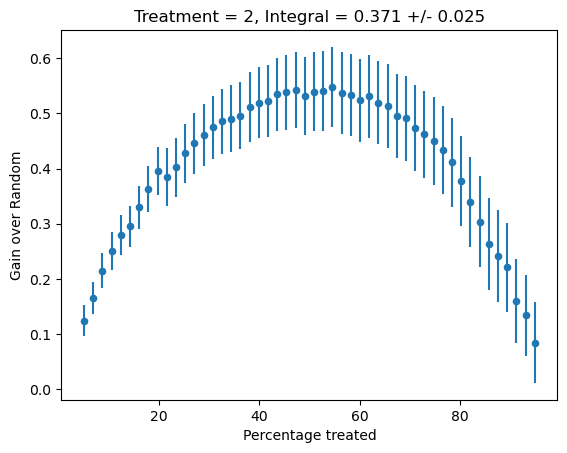

In [16]:
res_t.plot_qini(2)

<Axes: title={'center': 'Treatment = 1, Integral = -0.083 +/- 0.057'}, xlabel='Percentage treated', ylabel='Gain over Random'>

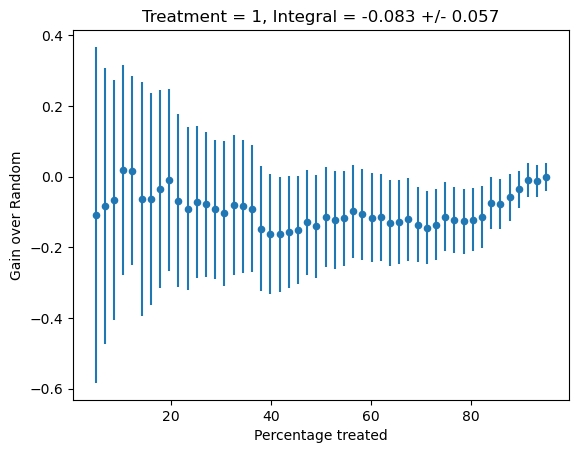

In [17]:
res_t.plot_toc(1)

<Axes: title={'center': 'Treatment = 2, Integral = 1.028 +/- 0.059'}, xlabel='Percentage treated', ylabel='Gain over Random'>

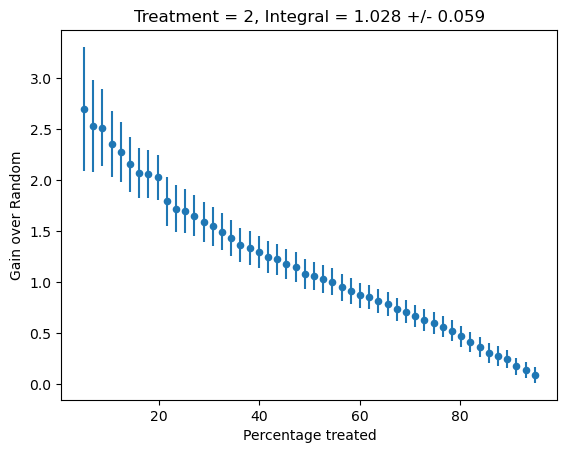

In [18]:
res_t.plot_toc(2)